## RQ2 Text Analysis

General plan:
- Follow a similar approach to the Chai-Allah "Data Mining..." paper to create clusters from the data
    - Just use tokenisation first, if 2 big then use lemmatisation
    - for now, just use all words (don't worry about filtering for high frequency words)
    - Use a German version of the word2vec model (see what the baroni one is based on and try to find a German equivalent)
    - use k-means or ward's for the clustering

Open Questions
- How should I handle placenames? See if they form clusters? Filter using gazetteer?
- **HOW DO I CONNECT TO CLASS 3 AND 6 AREAS?** Do I run them separately (but then end up with different clusters for each) or do I run the model on everything to create a classifier and then run that on the two separate corpora? I think the latter makes more sense but I don't really understand how this would work.


Steps:
1. Initial Cleaning
2. Language Handling 
3. Tokenisation
4. Pre-processing (filtering stop words etc, lower-case)
5. Semantic analysis (word2vec)
6. Clustering


In [1]:
# SETUP

# Import packages
import pandas as pd
import numpy as np
import pickle

import spacy 
from langdetect import detect
from deep_translator import GoogleTranslator
from collections import Counter
from gensim.models import KeyedVectors  # requires scipy version 1.12 (anything newer doesn't work)


from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
from wordcloud import WordCloud


### Step 1: Initial Cleaning

General text preparation to get the data in a format which works for translation and for use with spacy.

In [ ]:
# STEP 1: LOAD & CLEAN

# Load the master CSV from rq2_step1_data_collection
master = pd.read_csv("./processing/master.csv")

# Add ['None'] to any blank rows
# this is necessary for the next step, but then they will be removed later
master.fillna("['None']", inplace=True)

# Extract only the columns with text and combine them into a single column
# I am keeping the descriptions & photo captions separate from the comments as sometimes
# the comments are in a different language (so they need to be translated)
raw_text = pd.DataFrame()
raw_text["desc_capt"] = master["description text"] + " " + master["photo_captions"]
raw_text["comments"] = master["comments"] 

# Now remove all the ['None'] text from both columns
raw_text["desc_capt"] = raw_text["desc_capt"].str.replace(r"\['None'\]", "", regex=True)
raw_text["comments"] = raw_text["comments"].str.replace(r"\['None'\]", "", regex=True)

# Remove certain special characters: [, ], ', |, /, \ 
raw_text["desc_capt"] = raw_text["desc_capt"].str.replace(r"\[", "", regex=True)
raw_text["desc_capt"] = raw_text["desc_capt"].str.replace(r"\]", "", regex=True)
raw_text["desc_capt"] = raw_text["desc_capt"].str.replace(r"\'", "", regex=True)
raw_text["desc_capt"] = raw_text["desc_capt"].str.replace(r"\|", "", regex=True)
raw_text["desc_capt"] = raw_text["desc_capt"].str.replace(r"\\", "", regex=True)
raw_text["desc_capt"] = raw_text["desc_capt"].str.replace(r"\/", "", regex=True)

raw_text["comments"] = raw_text["comments"].str.replace(r"\[", "", regex=True)
raw_text["comments"] = raw_text["comments"].str.replace(r"\]", "", regex=True)
raw_text["comments"] = raw_text["comments"].str.replace(r"\'", "", regex=True)
raw_text["comments"] = raw_text["comments"].str.replace(r"\|", "", regex=True)
raw_text["comments"] = raw_text["comments"].str.replace(r"\\", "", regex=True)
raw_text["comments"] = raw_text["comments"].str.replace(r"\/", "", regex=True)

# This is to address a specific issue in one of the entries
raw_text["desc_capt"] = raw_text["desc_capt"].str.replace(r"\n", " ", regex=True)

# Create lists from the 2 columns
raw_text_p1 = raw_text["desc_capt"].astype(str).values.tolist()
raw_text_p2 = raw_text["comments"].astype(str).values.tolist()

# Convert entries which are just a space (" ") to be empty ("") - only needed for p1
raw_text_p1 = [x.strip(' ') for x in raw_text_p1]

# Remove all empty entries
raw_text_p1 = list(filter(None, raw_text_p1))
raw_text_p2 = list(filter(None, raw_text_p2))

# Combine into 1 list
raw_text_list = raw_text_p1 + raw_text_p2

# Check
raw_text_list

### Step 2: Language Handling: Translate to German

As the vast majority of text is in German, I will use this as the base language. I have the option now to either remove anything not in German or to translate it. Although translation is not ideal (maybe some of original meaning is lost/altered), I think this is a better option than just removing the other languages entirely. So here I will tranlsate everything into German. 

langdetect package: https://anaconda.org/conda-forge/langdetect 
- Use to check if already German

deep-translator package: https://pypi.org/project/deep-translator/
- Using Google Translate as it doesn't require API key and can auto detect the input language (DeepL requires API key and I don't think it has an auto-detect option)


In [ ]:
# STEP 2: TRANSLATE TO GERMAN (RUN ONCE!)

# Create list for all translated text
raw_text_de = []

# Check language, translate as needed and append to list 
for text_chunk in raw_text_list:
    # Check language
    input_lang = detect(text_chunk) 
    # If already German, append to German list
    if input_lang == "de":
        raw_text_de.append(text_chunk)
    # If not German, translate and append to German list    
    else:
        # Translate using Google Translate, use auto-detection for input language
        translated_chunk = GoogleTranslator(source='auto', target='de').translate(text=text_chunk)
        raw_text_de.append(translated_chunk)

# Check
raw_text_de


In [4]:
detect('Zorge Foto, Foto, Foto, Foto, Foto, Foto')

'it'

In [5]:
detect('Photo')

'vi'

## PROBLEM: 
"Foto" sometimes gets converted to "Fotos"! This is because langDetect assumes "Foto" is Italian and then translates that to "Fotos" in German

Testing with "Photo" also shows that it outputs Vietnamese??

Solutions?
- different language detector?
- remove "Fotos" as well as "Foto" (as stop word)  -- for now this is what I've done
- remove "Foto" earlier on in pre-processing

In [ ]:
# STEP 2: SAVE TRANSLATED TEXT

pickle.dump(raw_text_de, open("./processing/raw_text_de.p", "wb"))

In [72]:
# STEP 2: LOAD TRANSLATED TEXT

raw_text_de = pickle.load(open("./processing/raw_text_de.p", "rb"))

### Step 3: Tokenisation

German spacy model options: https://spacy.io/models/de 

de_core_news_sm (I've installed this one so far)
de_core_news_md
de_core_news_lg
de_dep_news_trf

Which is best to use?

**REVISIT THIS LATER**


In [73]:
# STEP 3: TOKENISATION

# Load the spacy model
nlp = spacy.load("de_core_news_sm")

# Create an empty list to store the tokens
doc = []

# Tokenise the raw_text input
for string in raw_text_de:
    doc.extend(nlp(string))

# Print the tokens to check
#for token in doc:
#    print(token)


### Step 4: Pre-processing 

Remove stop words, punctuation & numbers from the token list. 

Convert all to lower-case.

**Also:** 
- remove the word "Foto" as this is just placeholder text

In [75]:
# STEP 4: STOP WORDS ETC

# Add word "Foto" to stop list
nlp.vocab["Foto"].is_stop = True
nlp.vocab["Fotos"].is_stop = True

# Filter out tokens that are stop words (is_stop), puncutation (is_punct), 
# numbers (is_digit & like_num) OR spaces (is_space)
filtered_tokens = [token.text for token in doc if not token.is_stop | token.is_punct | 
                   token.is_digit | token.like_num | token.is_space]

# Empty list for lower-case versions
filtered_tokens_lc = []

# Convert to lower-case and remove any remaining white space
for token in filtered_tokens:
    token_lc = token.lower()
    token_lc.strip()
    filtered_tokens_lc.append(token_lc)

# Check
print(filtered_tokens_lc[0])

finndorff-blockland-st


In [76]:
# STEP 4: CHECKING SOME RESULTS? :) 

word_freq = Counter(filtered_tokens_lc)

common_words = word_freq.most_common(20)

common_words

[('hwn', 79),
 ('braunschweig', 65),
 ('weg', 37),
 ('harzer', 28),
 ('links', 27),
 ('rechts', 24),
 ('schöne', 22),
 ('brocken', 22),
 ('parkplatz', 21),
 ('wandernadel', 21),
 ('sachsenhagen', 21),
 ('start', 19),
 ('nummer', 19),
 ('wald', 18),
 ('st.', 17),
 ('bad', 16),
 ('tour', 16),
 ('export', 16),
 ('km', 15),
 ('route', 15)]

I think HWN stands for Harzer Wandernadel: a hiking badge system for the Harz mountains https://en.wikipedia.org/wiki/Harzer_Wandernadel

### STEP 5: Semantic analysis (word2vec)

Using the de_wiki word2vec model from https://sites.google.com/site/fritzgntr/software-resources/semantic_spaces because it is the closest one to the baroni model used in the Chai-allah paper but for German. 

The semantic spaces are provided in .rda format for R but can be export as a txt for use outside R using the following commands (in R). NOTE: I had to adjust from the instruction on the source website as it didn't account for use in gensim, which then meant I had problems with quotes and separators.

 load("C:/Users/ninam/Documents/UZH/04_Thesis/code/nm_forest_thesis/word2vec/de_wiki.rda")

 write.table(de_wiki, file = "C:/Users/ninam/Documents/UZH/04_Thesis/code/nm_forest_thesis/word2vec/de_wiki.txt", row.names = TRUE, col.names = FALSE, quote = FALSE, sep = " ")
 

 Some useful notes/resources:
 - "a word embedding refers to a vector representation of a particular word or phrase in a multidimensional space" (Generally this website is helpful: https://okan.cloud/posts/2022-05-02-text-vectorization-using-python-word2vec/)
 - https://medium.com/@dilip.voleti/classification-using-word2vec-b1d79d375381
 - https://medium.com/@denis.arvizu/text-clustering-using-word2vec-a89fbd9b9d0f

In [78]:
# STEP 5: MODEL PREP (RUN ONCE!)

# First I need to adjust the encoding and add the header information required by gensim
# Then I can save it in gensim format for easier use

# Count rows and vector size for header info
with open("./word2vec/de_wiki.txt", encoding="ISO-8859-1") as f:
    lines = f.readlines()

num_words = len(lines)
vector_size = len(lines[0].split()) - 1

# Write in utf-8 with header info
with open("./word2vec/de_wiki_utf8_header.txt", "w", encoding="utf-8") as f:
    f.write(f"{num_words} {vector_size}\n")
    f.writelines(lines)

# Load model (from new txt file) with gensim
model = KeyedVectors.load_word2vec_format("./word2vec/de_wiki_utf8_header.txt", binary=False)

# Save the model in optimised gensim format (this will make the loading faster for next time)
model.save("./word2vec/de_wiki_final.model")

In [79]:
# STEP 5: CHECKING MODEL

# Load model from model file
model = KeyedVectors.load('./word2vec/de_wiki_final.model')

# Which tokens are known versus which are missing in model?
known_tokens = [token for token in filtered_tokens_lc if token in model]
unique_known_tokens = set(known_tokens)
unique_known_count = len(unique_known_tokens)

missing_tokens = [token for token in filtered_tokens_lc if token not in model]
unique_missing_tokens = set(missing_tokens)
unique_missing_count = len(unique_missing_tokens)

print("Number of unique known tokens:", unique_known_count)
print("Number of unique missing tokens:", unique_missing_count)
print("Percentage missing:", round((unique_missing_count/unique_known_count *100), 2))
print("Missing tokens:", unique_missing_tokens)


Number of unique known tokens: 1673
Number of unique missing tokens: 674
Percentage missing: 40.29
Missing tokens: {'-fotos', 'tutsberg', 'knollmeyers', 'hiddensen', 'eichenkrug', 'brautste1', 'bergrat-müller-teich', '-solling', 'bismarckklippe', 'teufelsauper', 'walzenhütte', 'witttenmeer', 'stapenberg', 'radautal', 'querfeldeinpfade', 'ahlsburg', 'hwn001', 'gallhorn', 'oltermann', 'rodeberg', 'königsburgaltenau', 'ägidien', 'altenwalde-sahlenburg-duhnen-cuxhaven-altenwalde', 'eleonorenwald', 'stölzerne', 'niedernstöcken', 'wendlandtour', 'thale-', 'zillerbachtalsperre', 'oldtimertreff', 'osterfeine', 'benzingeroden', 'übernachtung', 'lindwedel', 'ü.', '-verbrennungsmittel', 'jägersbeeker', 'taubenklippe', 'abzeig', 'see1', 'försterblick', 'ngps', 'thalstein', 'siebersteinteich', 'gilten', 'eisland', 'pioniersteig', 'ziegenbuche', 'großraumparkpatz', 'srart', 'gpsies.com', 'rhodondendron', '-campingplatz', 'hoopte', 'teufelsstiegs', 'rabenklippe', 'bauökologischen', 'neuvrees', 'hirsc

In [80]:
# STEP 5: CONVERT TOKENS TO VECTORS (CREATE WORD EMBEDDINGS)

# Load model from model file
model = KeyedVectors.load('./word2vec/de_wiki_final.model')

# Create empty list to store vectors
vectors = []

# Create empty list to store valid tokens (i.e. tokens which are present in the model)
valid_tokens = []

# Store the vectors for each token
for token in filtered_tokens_lc:
    if token in model:
        vector = model[token]
        vectors.append(vector)
        valid_tokens.append(token)


In [81]:
# STEP 5: COSINE SIMILARITY/DISIMILARITY

# Approximate cosine similarity (for kmeans)
normalised_vectors = normalize(vectors)


### Step 6: Clustering

I'll try it out with k-means first.

First step is to see how many clusters I should make using the elbow method.

Note I got the following error message when running this originally: *UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.* To resolve this I edited the **system environment variables** using the instructions in the first answer here: https://stackoverflow.com/questions/69596239/how-to-avoid-memory-leak-when-dealing-with-kmeans-for-example-in-this-code-i-am

Resources
- GEO881 Assignment 1, Part 2 (kmeans classification - but in R)
- https://www.w3schools.com/python/python_ml_k-means.asp
- https://medium.com/@m3redithw/wordclouds-with-python-c287887acc8b


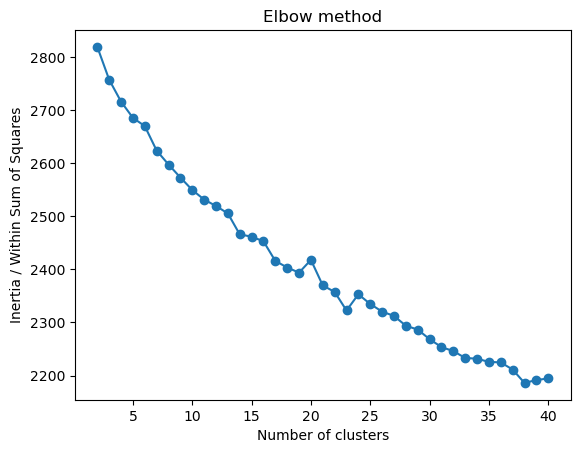

In [82]:
# STEP 6: DETERMINE NUMBER OF CLUSTERS

# Set seed for reproducible results
np.random.seed(244)

# Create empty list to intertias (within cluster sum of squares)
inertias = []

# Test kmeans intertias/within ss for 2-40 clusters
for k in range(2,41):
  kmeans = KMeans(n_clusters=k, max_iter=200)
  kmeans.fit(normalised_vectors)
  inertias.append(kmeans.inertia_)

# Generate the elbow plot
plt.plot(range(2,41), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia / Within Sum of Squares')
plt.show() 

Based on plot above - 14 clusters?

In [83]:
# STEP 6: KMEANS WITH 14 CLUSTERS

# Set seed for reproducible results
np.random.seed(11)

# Define number of clusters basedon elbow plot
n_clusters = 14

# Generate kmeans clusters and labels
kmeans = KMeans(n_clusters=n_clusters)
kmeans.fit(normalised_vectors)
labels = kmeans.labels_

# Create a df with the cluster number for each token contained in the model
token_cluster_all = pd.DataFrame({"token": valid_tokens, "cluster": labels})

# Check
token_cluster_all


,token,cluster
0,pause,2
1,wümme,5
2,deich,13
3,wümme,5
4,deich,13
...,...,...
3208,staumauer,13
3209,gesperrt,10
3210,größerer,10
3211,umweg,9


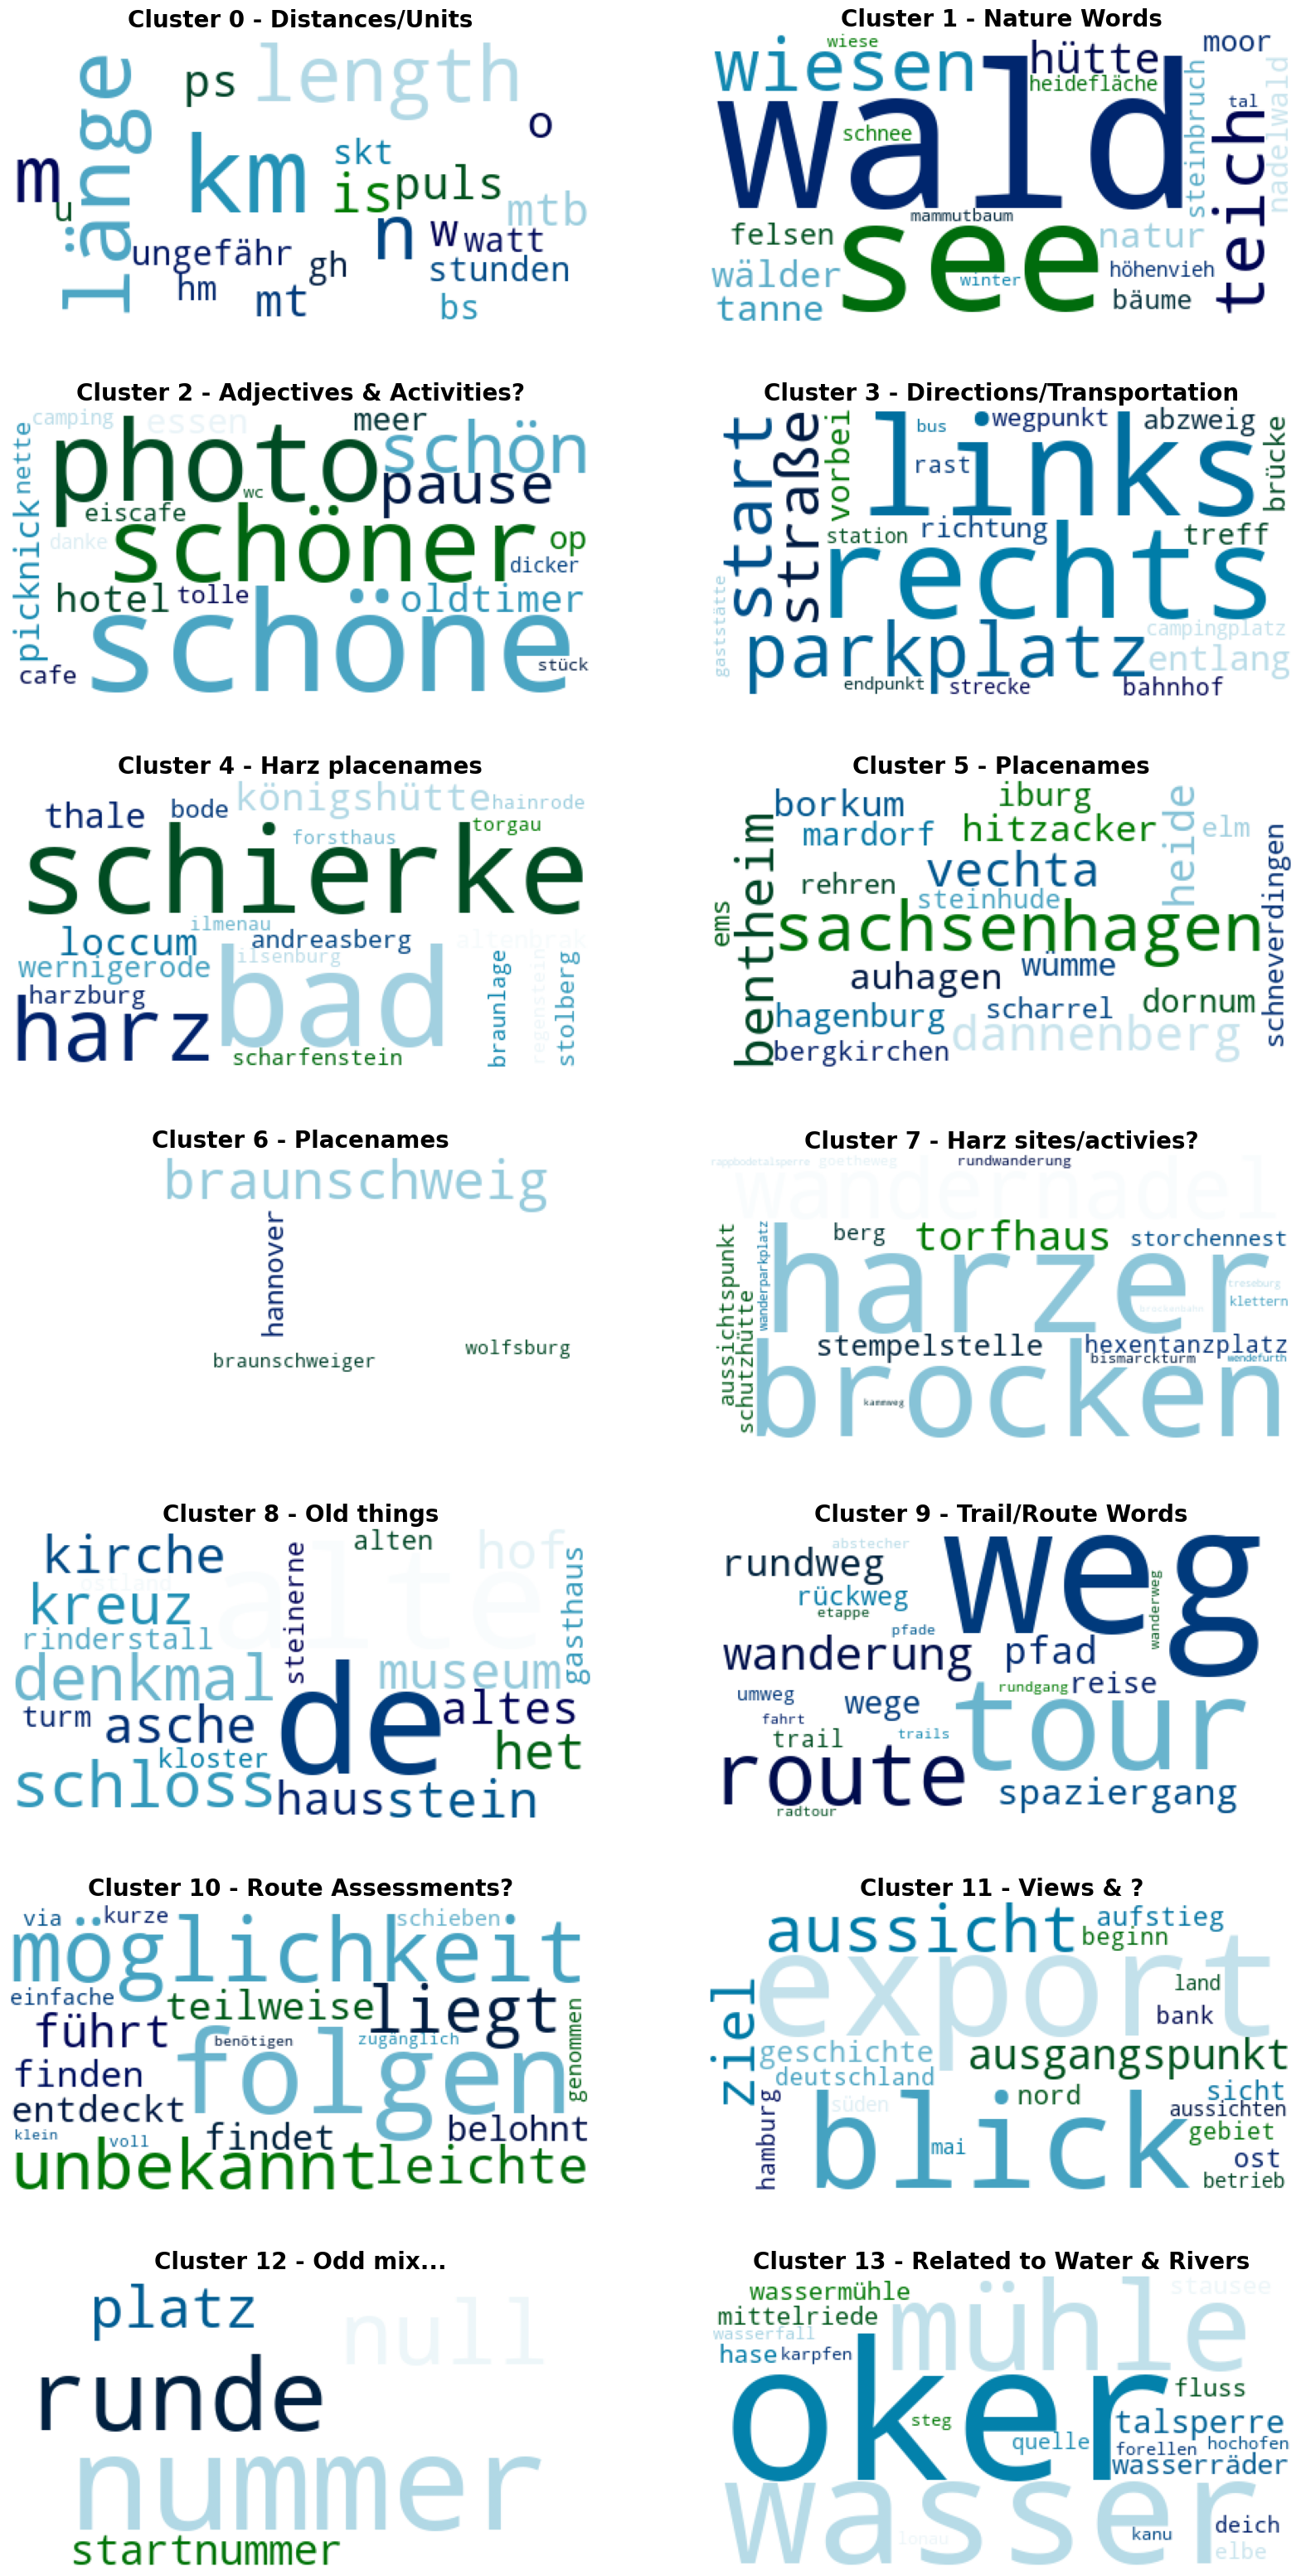

In [112]:
# STEP 6: EXPLORE CLUSTER WORD CLOUDS

# Create a function to count the token frequencies for each cluster 
def get_cluster_freq(df, clus_num):
    token_list = df.loc[df["cluster"] == clus_num, "token"]
    delimiter = " " 
    join_str = delimiter.join(token_list)
    freqs = Counter(join_str.split())
    return freqs

# Create empty lists for storing the word cloud plots 
all_wc = []

# For each cluster number (0-13) use the get_cluster_freq function to get token frequencies,
# input those frequencies into the WordCloud generator and append each wc to list
# IMPORTANT: I HAVE LIMITED TO SHOW TOP 20 TOKENS IN EACH CLUSTER
for clus_num in range(14):  
    freqs = get_cluster_freq(token_cluster_all, clus_num)
    wc = WordCloud(background_color='white', 
                   colormap='ocean', 
                   max_words=20).generate_from_frequencies(freqs)
    all_wc.append(wc)

# Create custom titles
all_titles = ["Cluster 0 - Distances/Units", "Cluster 1 - Nature Words", 
              "Cluster 2 - Adjectives & Activities?",  "Cluster 3 - Directions/Transportation", 
              "Cluster 4 - Harz placenames", "Cluster 5 - Placenames", 
              "Cluster 6 - Placenames", "Cluster 7 - Harz sites/activies?", 
              "Cluster 8 - Old things", "Cluster 9 - Trail/Route Words",
              "Cluster 10 - Route Assessments?", "Cluster 11 - Views & ?",
              "Cluster 12 - Odd mix...", "Cluster 13 - Related to Water & Rivers"]

# Create a figure with 14 subplots
fig, axes = plt.subplots(nrows=7, ncols=2, figsize=(20, 40))
axes = axes.flatten()

# Iterate through word clouds and titles to plot
for i, (wc, title) in enumerate(zip(all_wc, all_titles)):
    axes[i].imshow(wc)
    axes[i].axis('off')
    axes[i].set_title(title, fontsize=20, fontweight="bold")

# Display final figure
plt.show()


